## Import Packages and Modules

In [1]:
import os, glob
import pandas as pd
import numpy as np
import math, random
from datetime import datetime
import pickle
from matplotlib import pyplot as plt
import argparse
import path, sys, re, time
from collections import Counter
from scipy.signal import find_peaks



from module_.readText import read_hh
from module_.featureExtraction import feature_extraction
from module_.changePointDetection import change_point_detection
from module_.info.hh import baseline_activities
from module_.info.config import feature_name, exclude_list

## Load Dataset: hh101

In [2]:
events=np.load("./preprocessed/test/ann.npy")

print("""Raw events: {}
First 5 Raw events:
{}""".format(events.shape, events[:5]))

Raw events: (322603, 4)
First 5 Raw events:
[['D001' 'CLOSE' '1342583685.126257' '']
 ['D002' 'OPEN' '1342583685.196564' '']
 ['T102' '78' '1342583685.247825' '']
 ['BATP102' '85' '1342583685.302398' '']
 ['BATV102' '2830' '1342583685.354045' '']]


## Data Preprocessing

In [3]:
# INCLUDE ONLY "MOTION and DOOR"
# events_md=np.array([event for event in events if event[3]!="" and event[0][0] in ['M', 'D']])
events_md = np.array([event for event in events if event[0][0] in ['M', 'D']])
# events_md = events

# MAPPING TO PRE-DEFINED ACTIVITY
for i in range(events_md.shape[0]):
    events_md[i,3]=baseline_activities[events_md[i,3]]

# TRANSITION POINTS
trs_md = np.array([i for i in range(len(events_md)) if events_md[i][3]!=events_md[max(i-1,0)][3]])

# Sensor List
sensor_list = sorted(set(events_md[:,0]))

print(
"""The number of events: {},
The number of transitions: {},
The number of sensors: {}""".format(len(events_md), len(trs_md), len(sensor_list)))

print(Counter([events_md[i,3] for i in trs_md]))

The number of events: 219511,
The number of transitions: 2556,
The number of sensors: 18
Counter({'Other': 1151, 'Sleep': 284, 'Leave_Home': 216, 'Enter_Home': 216, 'Personal_Hygiene': 154, 'Cook': 151, 'Eat': 107, 'Wash_Dishes': 106, 'Relax': 92, 'Bathe': 59, 'Bed_Toilet_Transition': 17, 'Work': 3})


## Feature Extraction

In [4]:
data_name = "hh101"
choose_type = "A"

if os.path.exists("./replication/{}/features_{}.npy".format(data_name, choose_type)):
    choose_features = np.load("./replication/{}/features_{}.npy".format(data_name, choose_type))
else:
    raw_features = np.array(feature_extraction(events_md, data_name, sensor_list))

    choose_features = []
    for i in range(raw_features.shape[1]):
        if i not in exclude_list[choose_type]:
            choose_features.append(raw_features[:,i].reshape(-1,1))
    choose_features = np.concatenate(choose_features, axis=1)

    np.save("./replication/hh101/features_{}.npy".format(choose_type), choose_features)

    print("""Raw features: {}
    Excluded features: {}
    Chosen features: {}""".format(raw_features.shape, [feature_name[i] for i in exclude_list[choose_type]], choose_features.shape))

## Dissimilarity Scoring

In [5]:
metric = "SEP"
scores = np.array(change_point_detection(choose_features, data_name=data_name, metric=metric))

np.save("./replication/hh101/scores_{}.npy".format(metric), scores)
np.save("./replication/hh101/transitions.npy", trs_md)

10000/219511 (accumulated) time: 98.58966493606567
20000/219511 (accumulated) time: 197.16417002677917
30000/219511 (accumulated) time: 286.6330714225769
40000/219511 (accumulated) time: 372.46344089508057
50000/219511 (accumulated) time: 459.01045656204224
60000/219511 (accumulated) time: 546.2841577529907
70000/219511 (accumulated) time: 632.805899143219
80000/219511 (accumulated) time: 719.4650151729584
90000/219511 (accumulated) time: 805.8532552719116
100000/219511 (accumulated) time: 894.2348139286041
110000/219511 (accumulated) time: 983.0404224395752
120000/219511 (accumulated) time: 1071.6611123085022
130000/219511 (accumulated) time: 1159.7951846122742
140000/219511 (accumulated) time: 1245.7394580841064
150000/219511 (accumulated) time: 1331.4714710712433
160000/219511 (accumulated) time: 1417.423137664795
170000/219511 (accumulated) time: 1503.0330624580383
180000/219511 (accumulated) time: 1588.8063123226166
190000/219511 (accumulated) time: 1674.8665149211884
200000/21951

## Evaluation

In [11]:
scores = np.load("./replication/hh101/scores_RuLSIF.npy")
# transitions = np.load("./replication/hh101/transitions.npy")

threshold = 0.1
interval = 10
# Reject scores lower than threshold
# scores[scores<threshold] = 0

# Choose peak scores (one score in the range: 2*interval)
finalists=[]
prevtimestamp = 0
for i in range(len(scores)):
    # if scores[i]>threshold and float(events_md[i, 2])-prevtimestamp>2*interval:
    #     finalists.append(i)
    #     prevtimestamp = float(events_md[i, 2])
    if scores[i]>threshold:
        finalists.append(i)

groundtruth = np.array([float(events_md[i, 2]) for i in trs_md])

print(len(groundtruth), len(finalists))

2556 15667


In [12]:
# Evaluation
truePositive = trueNegative = falsePositive = falseNegative = 0
for i in range(len(events_md)):
    if i in finalists: # Positive
        if i in trs_md: # True
            truePositive+=1
        else:
            timeGap = abs(groundtruth - float(events_md[i, 2]))
            if sum(timeGap<interval)!=0:
                truePositive+=1
            else:
                falsePositive+=1
    else: # Negative
        if i in trs_md: # False
            falseNegative+=1
        else:
            trueNegative+=1

print(truePositive/(truePositive+falseNegative))
print(falsePositive/(falsePositive+trueNegative))

0.2869097429766886
0.06803599102537414


# 2. Analysis

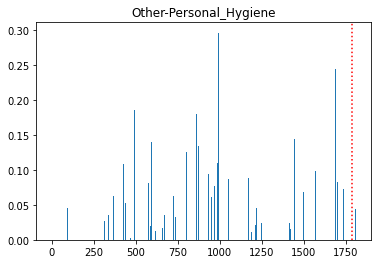

In [8]:
episodes, trs, tags = [], [], []
previdx=0
for i in range(len(trs_md)-1):
    left=np.array(events_md[previdx:trs_md[i]])
    right=np.array(events_md[trs_md[i]:trs_md[i+1]])
    episode=np.concatenate((left, right))
    episodes.append(episode)
    trs.append(left.shape[0])
    pairname="{}-{}".format(left[0][3], right[0][3])
    tags.append(pairname)
    previdx=trs_md[i]

data_name = 'hh101'
metric = 'SEP'
dataset_folder = './features/{}'.format(data_name)

sensor_list = sorted(set(events_md[:,0]))

if not os.path.exists(dataset_folder):
    os.mkdir(dataset_folder)

for ei, eps in enumerate(episodes):
    transition_point = trs[ei]
    features = feature_extraction(eps, data_name, sensor_list)
    features = np.array(features)

    folder_ = "./features/{}/{}/{}".format(data_name, tags[i], i)
    x_ = range(len(eps))

    scores=np.array(change_point_detection(features, data_name=data_name, metric=metric))
    scores[scores<0]=0
    plt.title(tags[i])
    plt.bar(range(len(scores)), scores); plt.axvline(x=transition_point, linestyle=':', color='r')
    
    break